In [2]:
# Pagrindinės bibliotekos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Vizualizacijai, atkreipkite dėmesį, kad naudojame "matplotlib" pagrindu
import warnings
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import time
import sqlite3

# Duomenų modeliavimas ir analizė
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Darbas su interneto naršyklėmis per Selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Įspėjimų ignoravimas
warnings.filterwarnings('ignore')

# Specializuoti moduliai
from numpy.polynomial import Polynomial

In [ ]:
data

In [8]:
data = r"C:\Users\Pauliussl\Paskaita82\data_tuberkulioze.csv"
data = pd.read_csv(data)
data.drop(columns=['_type'], inplace=True)
data.head()

new_data = data[['paciento_id','paciento_gim_metai','paciento_lytis','rukymas_id', 'rukymas_reiksme', 'rukymo_stazas_id','rukymo_stazas_reiksme','alkoholis_id', 'alkoholis_reiksme', 'ar_mire_nuo_tub', 'mirties_nuo_tub_d']]
new_data.dropna(inplace=True)
new_data['mirties_nuo_tub_d'] = pd.to_datetime(new_data['mirties_nuo_tub_d'], errors='coerce')
new_data['paciento_gim_metai'] = pd.to_datetime(new_data['paciento_gim_metai'], errors='coerce')
new_data['amzius'] = new_data['mirties_nuo_tub_d'] - new_data['paciento_gim_metai']
new_data['amzius'] = new_data['amzius'].dt.days / 365
new_data

,paciento_id,paciento_gim_metai,paciento_lytis,rukymas_id,rukymas_reiksme,rukymo_stazas_id,rukymo_stazas_reiksme,alkoholis_id,alkoholis_reiksme,ar_mire_nuo_tub,mirties_nuo_tub_d,amzius
7,00068dce2ac554f,1951-01-01,V,2.0,11-20 cigarečių per dieną,4.0,Virš 20 metų,3.0,Girtauja,False,2007-01-28,56.112329
11,00097b2301af60e,1985-01-01,V,2.0,11-20 cigarečių per dieną,2.0,1 - 10 metų,2.0,Vartoja retai,True,2012-04-14,27.301370
31,001e361c3b3c953,1926-01-01,V,2.0,11-20 cigarečių per dieną,4.0,Virš 20 metų,2.0,Vartoja retai,False,1999-04-06,73.309589
86,00567bd6cc1f5fb,1966-01-01,V,1.0,Iki 10 cigarečių per dieną,3.0,11 - 20 metų,3.0,Girtauja,True,2004-07-18,38.569863
101,00613bb97087d11,1967-01-01,V,2.0,11-20 cigarečių per dieną,3.0,11 - 20 metų,2.0,Vartoja retai,True,2022-04-12,55.315068
...,...,...,...,...,...,...,...,...,...,...,...,...
52032,ff7134e887dd768,1954-01-01,M,2.0,11-20 cigarečių per dieną,3.0,11 - 20 metų,2.0,Vartoja retai,False,2008-10-26,54.854795
52044,ff82486b0b1fdc0,1956-01-01,V,3.0,Virš 20 cigarečių per dieną,3.0,11 - 20 metų,4.0,Alkoholikas,True,2007-10-11,51.810959
52068,ff9dafa09daeba8,1935-01-01,V,5.0,Eksrūkorius,4.0,Virš 20 metų,3.0,Girtauja,True,2001-02-27,66.202740
52082,ffb436deec5a6d1,1936-01-01,V,1.0,Iki 10 cigarečių per dieną,4.0,Virš 20 metų,2.0,Vartoja retai,False,2000-09-17,64.756164


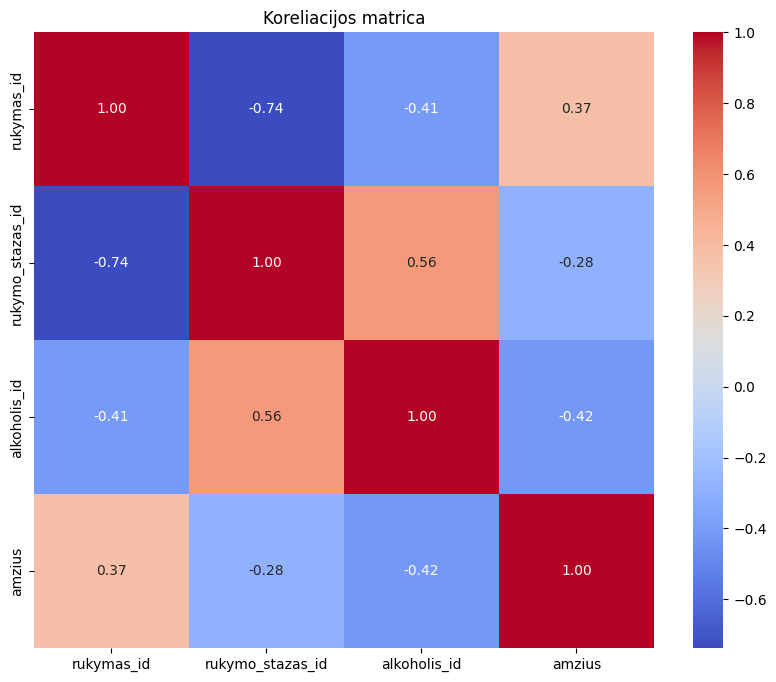

In [ ]:
# Nusibreziame correlation matrix (netinkama del nerukanciu kurie yra = 4)
new_data2 = new_data[['rukymas_id', 'rukymo_stazas_id', 'alkoholis_id', 'amzius']]
correlation_matrix = new_data2.corr()  # 'new_data' turėtų būti jūsų DataFrame

plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Koreliacijos matrica')
plt.show()


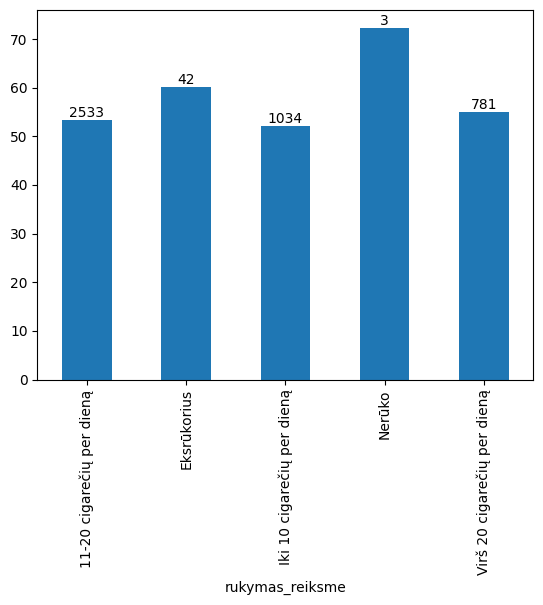

In [ ]:
# Ar yra priklausomybė tarp gyvenimo trukmės ir TBC žalingų įpročių?

rukymo_daznis = new_data[['rukymas_reiksme', 'amzius']]
grupuoti_duomenys = rukymo_daznis.groupby('rukymas_reiksme')['amzius'].mean()

count_skaicius = rukymo_daznis.groupby('rukymas_reiksme')['amzius'].count()

fig, ax = plt.subplots()
grupuoti_duomenys.plot(kind='bar')

for i, x in enumerate(count_skaicius):
    ax.text(i, grupuoti_duomenys[i], str(x), ha='center', va='bottom')

plt.show()


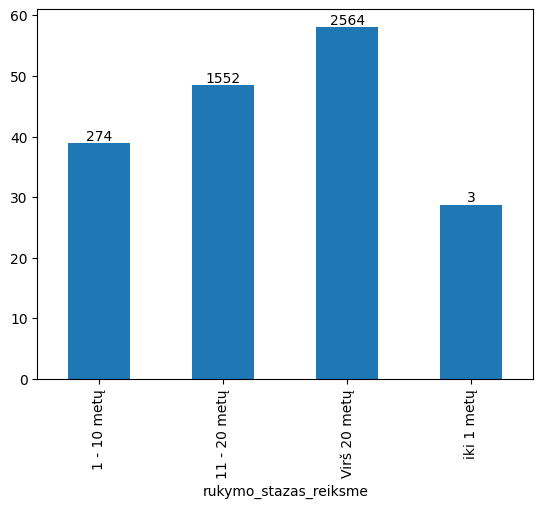

In [19]:
rukymo_stazas = new_data[['rukymo_stazas_reiksme', 'amzius']]
grupuoti_duomenys = rukymo_stazas.groupby('rukymo_stazas_reiksme')['amzius'].mean()

count_skaicius = rukymo_stazas.groupby('rukymo_stazas_reiksme')['amzius'].count()

fig, ax = plt.subplots()
grupuoti_duomenys.plot(kind='bar')

for i, x in enumerate(count_skaicius):
    ax.text(i, grupuoti_duomenys[i], str(x), ha='center', va='bottom')

plt.show()

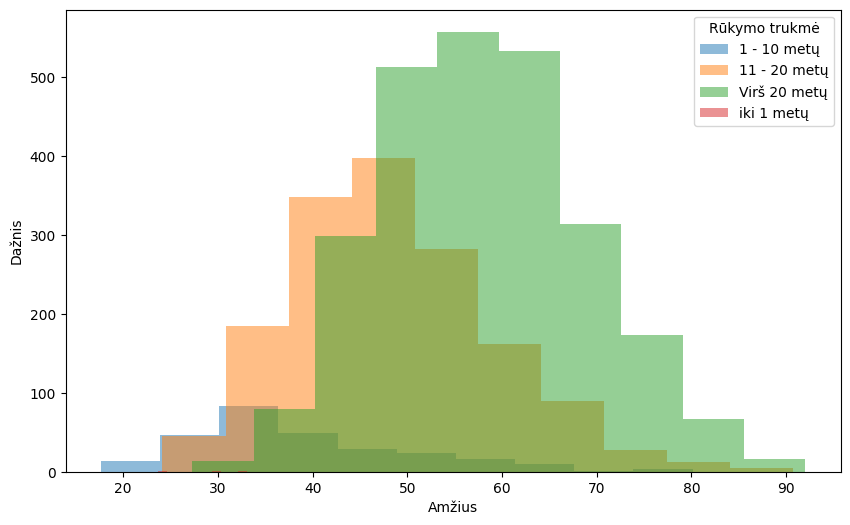

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

data = new_data[['rukymo_stazas_reiksme', 'amzius']]
grouped_data = data.groupby('rukymo_stazas_reiksme')['amzius'].apply(list)

plt.figure(figsize=(10, 6))
for key, values in grouped_data.items():
    plt.hist(values, bins=10, alpha=0.5, label=str(key))

plt.xlabel('Amžius')
plt.ylabel('Dažnis')
plt.legend(title='Rūkymo trukmė')
plt.show()


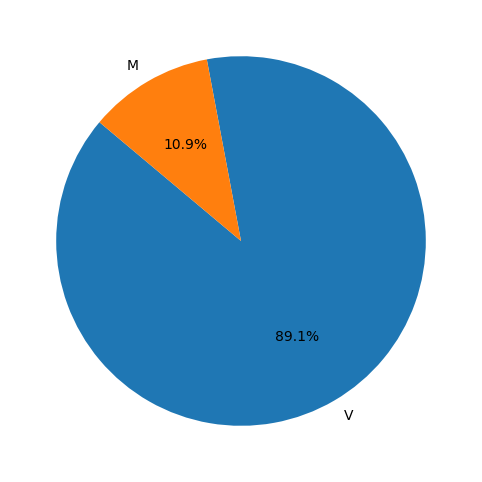

In [30]:
# Pateikite TBC sergančiųjų duomenų apžvalgą: pasiskirstymas pagal lytį, amžių, rūkymo/alkoholio vart. stažą.
new_data

lyties_pasiskirstymas = new_data['paciento_lytis'].value_counts()

plt.figure(figsize=(8,6))
plt.pie(lyties_pasiskirstymas, labels=lyties_pasiskirstymas.index, autopct='%1.1f%%', startangle=140)
plt.show()



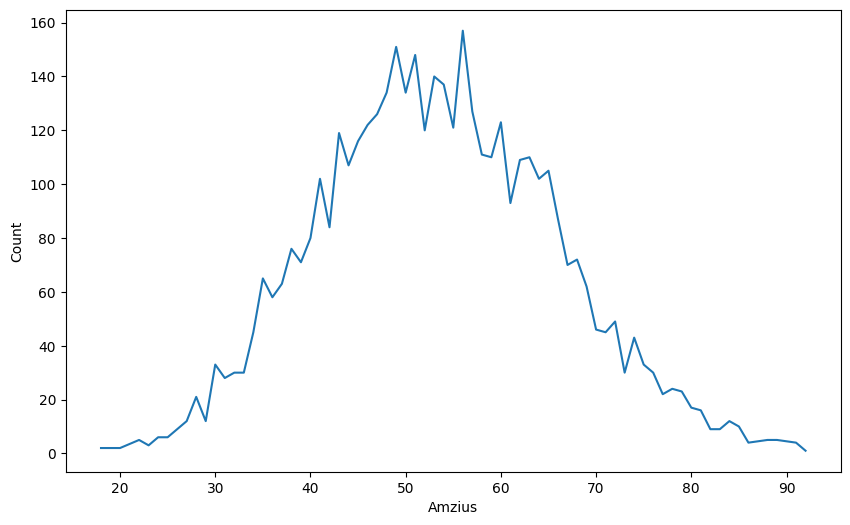

In [38]:
amziaus_pasiskirstymas = new_data['amzius'].round().value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(amziaus_pasiskirstymas.index, amziaus_pasiskirstymas.values)

plt.xlabel('Amzius')
plt.ylabel('Count')
plt.show()

In [51]:
# Parašykite skriptą, kuris prognozuotų tikėtiną paciento gyvenimo trukmę.

new_data3 = new_data[['rukymas_id', 'rukymo_stazas_id', 'alkoholis_id', 'paciento_lytis', 'amzius']]
new_data3['paciento_lytis'] = new_data3['paciento_lytis'].map({'V':0, 'M':1})
new_data3

y= new_data3.amzius
Xtrain = new_data3.drop(['amzius'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2, random_state=42)

### Random forrest regression ###

model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('Absoliucioji paklaida Random Forrest regression:', mae)


### Linear regression ###

model2 = LinearRegression()
model2.fit(X_train, y_train)
predictions2 = model2.predict(X_test)

mae2 = mean_absolute_error(y_test, predictions2)
print('Absoliucioji paklaida Linear regression:', mae2)

### Decision Tree regression ###

model3 = DecisionTreeRegressor()
model3.fit(X_train, y_train)
predictions3 = model3.predict(X_test)

mae3 = mean_absolute_error(y_test, predictions3)
print('Absoliucioji paklaida Decision Tree regression:', mae3)

Absoliucioji paklaida Random Forrest regression: 8.511401061079706
Absoliucioji paklaida Linear regression: 8.39856610473368
Absoliucioji paklaida Decision Tree regression: 8.502734784620534
